# Programming Assignment II: Quantum Circuits and Gates - Bell's Circuit and SWAP Test

## Task 1.1

In [1]:
import numpy as np

DTYPE = np.complex128

def ket00():
    """Return |00> as a length‑4 complex column vector."""
    v = np.zeros(4, dtype=DTYPE)
    v[0] = 1.0
    return v

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return v / n

# Example
psi = ket00()
assert np.isclose(np.linalg.norm(psi), 1.0)

The basis is constructed in the following order: $\ket{q_0 q_1} = \ket{00}, \ket{01}, \ket{10}, \ket{11}$

To map a bitstring to the corresponding index, we use the next relation:

$i = 2 q_0 + q_1$

## Task 1.2

In [2]:
# 1‑qubit and 2‑qubit gate definitions (matrix form)
I2 = np.array([[1, 0], [0, 1]], dtype=DTYPE)
H  = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=DTYPE)

# CNOT with control = q0 (MSB), target = q1 (LSB) in basis |q0 q1>
CNOT_01 = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
], dtype=DTYPE)

# Expand a 1‑qubit unitary U to a 2‑qubit operator acting on target qubit t in |q0 q1> order
# t = 0 applies to q0 (MSB); t = 1 applies to q1 (LSB)

def expand_1q(U: np.ndarray, t: int) -> np.ndarray:
    if t == 0:   # act on q0 (MSB)
        return np.kron(U, I2)
    elif t == 1: # act on q1 (LSB)
        return np.kron(I2, U)
    else:
        raise ValueError("target index must be 0 or 1")

# Apply a gate matrix to a state vector

def apply(U: np.ndarray, psi: np.ndarray) -> np.ndarray:
    return U @ psi

# Quick unit tests
assert np.allclose(H.conj().T @ H, I2)
assert np.allclose(CNOT_01.conj().T @ CNOT_01, np.eye(4))

In this code, the CNOT gate uses $q_0$ (MSB) as the control and $q_1$ (LSB) as the target, while keeping the same $\ket{q_0 q_1}$ basis ordering. If the control qubit $q_0$ is 1, the gate flips (applies NOT to) the target qubit $q_1$.

## Task 1.3

In [3]:
def bell_state() -> np.ndarray:
    psi = ket00()
    # H on q0 (MSB), then CNOT(control=q0, target=q1)
    psi = apply(expand_1q(H, t=0), psi)
    psi = apply(CNOT_01, psi)
    return normalize(psi)

psi_bell = bell_state()
print("Bell state vector:", np.round(psi_bell, 6))

# Expected amplitudes (up to a global phase): [1/√2, 0, 0, 1/√2]

expected = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=DTYPE) # The theoretical expected result
inner = np.dot(psi_bell, expected)
gl_phase = inner / np.abs(inner)
assert np.allclose(psi_bell, gl_phase * expected)

Bell state vector: [0.707107+0.j 0.      +0.j 0.      +0.j 0.707107+0.j]


## Task 1.4

{'00': 4983, '01': 0, '10': 0, '11': 5017}


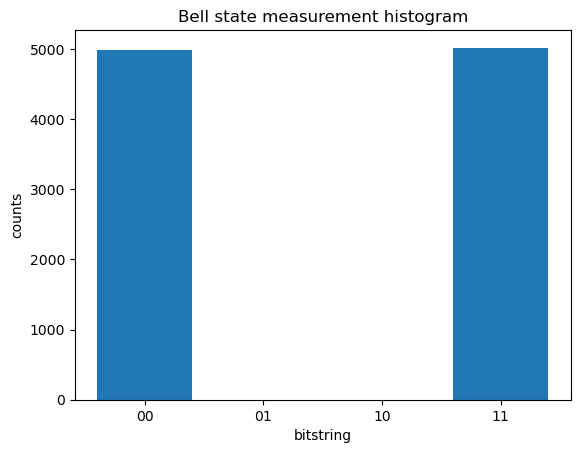

In [4]:
import matplotlib.pyplot as plt

BITSTR = ["00","01","10","11"]

def sample_bitstrings(psi: np.ndarray, shots: int = 10_000, seed: int = 7):
    rng = np.random.default_rng(seed)
    probs = np.abs(psi)**2
    idx = rng.choice(4, size=shots, p=probs)
    return idx

# Sample from Bell state
shots = 10_000
idx = sample_bitstrings(psi_bell, shots=shots)

# Make histogram
counts = {b: int(np.sum(idx == i)) for i, b in enumerate(BITSTR)}
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstring"); plt.ylabel("counts"); plt.title("Bell state measurement histogram")
plt.show()

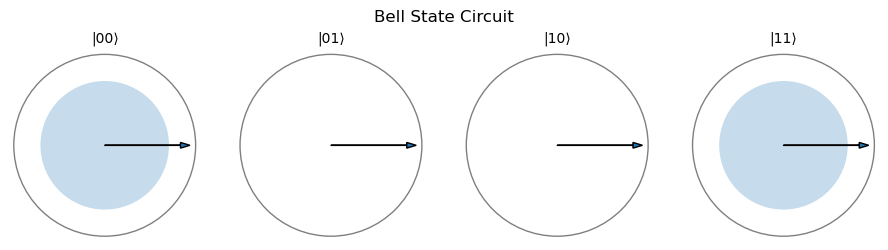

In [5]:
import math

class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        if sv.ndim != 1:
            raise ValueError("Statevector must be 1D.")
        n_states = sv.size
        n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Length must be a power of 2.")
        # Defensive normalization (harmless if already normalized)
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm

        self.n_qubits = n_qubits
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))

        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")

            if idx >= self.n_states:
                ax.set_visible(False)
                continue

            # Outer reference circle
            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))

            # Filled disk: radius ∝ sqrt(probability) so area ∝ probability
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            # Phase arrow
            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L * np.cos(angle)
            y2 = 0.5 + L * np.sin(angle)
            ax.arrow(0.5, 0.5, x2 - 0.5, y2 - 0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)

            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()

bs_system = QubitSystem(psi_bell, "Bell State Circuit")
bs_system.viz_circle()

The only two possible states of the system are $\ket{00}$ and $\ket{11}$ since the other basis states have zero amplitude. Both components have the same relative phase, as neither the Hadamard nor the CNOT gate introduces a phase difference. The circle plot shows that the measurement probabilities for $\ket{00}$ and $\ket{11}$ are equal, indicated by the equal size of the blue circles.

## Task 2

In [6]:
def expand_1q_n(U: np.ndarray, t: int, n: int) -> np.ndarray:
    op = np.array([[1]], dtype=U.dtype)
    for q in range(n):
        op = np.kron(op, U if q == t else I2)
    return op

# Apply CSWAP, with ancilla as control
P0 = np.array([[1,0],[0,0]], dtype=DTYPE)  # |0><0| on ancilla
P1 = np.array([[0,0],[0,1]], dtype=DTYPE)  # |1><1| on ancilla
SWAP_A0_B0 = np.array([
    [1,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,0,0,1]
], dtype=DTYPE)  # SWAP on A0 and B0
CSWAP = (np.kron(P0, np.eye(4)) + np.kron(P1, SWAP_A0_B0)) # CSWAP with ancilla as control

#### Function to run the SWAP test circuit for given input states

In [7]:
def run_swap_test(psi, phi):
    assert np.isclose(np.sum(np.abs(psi)**2), 1)
    assert np.isclose(np.sum(np.abs(phi)**2), 1)
    init = np.kron(np.array([1,0], dtype=DTYPE), np.kron(psi, phi))  # |0>_output ⊗ |ψ>_A ⊗ |φ>_B

    # Quantum Circuit
    U_Ho = expand_1q_n(H, t=0, n=3)
    state = U_Ho @ init # first Hadamard
    state = CSWAP @ state # CSWAP
    state = U_Ho @ state # second Hadamard

    # Calculate observed/theoretical fidelity
    probs = np.abs(state)**2
    prob_1 = probs[4:].sum()   # indices with output=1
    F_hat = 1 - 2*prob_1
    F_exact = float(np.abs(np.vdot(psi/np.linalg.norm(psi), phi/np.linalg.norm(phi)))**2)
    
    return prob_1, F_hat, F_exact

#### Case 1: $\ket{\psi} = \ket{\varphi}$

In [8]:
psi = np.array([1, 0], dtype=DTYPE) # INPUT 1
phi = np.array([1, 0], dtype=DTYPE) # INPUT 2

# Run the swap test
prob_1, F_hat, F_exact = run_swap_test(psi, phi)

# TESTS
assert np.allclose(prob_1, 0)
assert np.allclose(F_hat, F_exact, 1)

#### Case 2: $\ket{\psi} = \ket{0}, \ket{\varphi} = \ket{1}$

In [9]:
psi = np.array([1, 0], dtype=DTYPE) # INPUT 1
phi = np.array([0, 1], dtype=DTYPE) # INPUT 2

# Run the swap test
prob_1, F_hat, F_exact = run_swap_test(psi, phi)

# TESTS
assert np.allclose(prob_1, 0.5)
assert np.allclose(F_hat, F_exact, 0)

#### Case 3: $\ket{\psi} = \ket{+}, \ket{\varphi} = \ket{1}$

In [10]:
psi = np.array([1/np.sqrt(2), 1/np.sqrt(2)], dtype=DTYPE) # INPUT 1
phi = np.array([0, 1], dtype=DTYPE) # INPUT 2

# Run the swap test
prob_1, F_hat, F_exact = run_swap_test(psi, phi)

# TESTS
assert np.allclose(prob_1, 0.25)
assert np.allclose(F_hat, F_exact, 0.5)

As opposed to the lecture videos, this SWAP-test circuit does not have a final NOT gate. Consequently when exactly the same qubits are swapped, we will measure the output bit as 1 with a 0% chance (or 50% chance when the inputs are opposites). Using these probabilities, the output bit defines the Fidelity which is the measure for overlap.

$F = 1 - 2 P(\text{out} = 1)$

## Bonus Exercise

### Task B.1 — Basis vs $\ket{5}$: design, simulate, evaluate

In [11]:
# Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np
import pandas as pd
from math import sqrt
from tabulate import tabulate

#### Helper functions

In [12]:
def basis_state_prep(qc, qubits, k, n_qubits=3):
    """Prepare computational-basis state |k> on given qubit indices."""
    bits = [(k >> i) & 1 for i in range(n_qubits)][::-1]  # MSB first
    for qb, b in zip(qubits, bits):
        if b == 1:
            qc.x(qb)

def swap_test_3qubit(k_ref, k_test):
    """Build SWAP-test circuit comparing 3-qubit basis states k_ref and k_test."""
    output = QuantumRegister(1, 'output')
    R = QuantumRegister(3, 'R')  # reference
    L = QuantumRegister(3, 'L')  # test
    cbit = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(output, R, L, cbit)

    # Prepare basis states
    basis_state_prep(qc, R, k_ref)
    basis_state_prep(qc, L, k_test)

    # SWAP test
    qc.h(output[0])
    for i in range(3):
        qc.cswap(output[0], R[i], L[i])  # Ri ↔ Li controlled by output
    qc.h(output[0])

    qc.measure(output[0], cbit[0])
    return qc

def estimate_fidelity_from_counts(counts):
    """Return estimated fidelity F = 1 - 2*P(1) from counts."""
    shots = sum(counts.values())
    p1 = counts.get('1', 0) / shots
    f_est = max(0.0, min(1.0, 1 - 2*p1))
    return f_est, p1


def fidelity_and_se(counts, shots):
    f, p1 = estimate_fidelity_from_counts(counts)
    # Binomial SE for p1
    se_p1 = sqrt(p1 * (1 - p1) / shots)
    # Propagate error: F = 1 - 2*p1 ⇒ dF/dp1 = -2
    se_f = 2 * se_p1
    return f, se_f

#### Circuit Design Analysis

**Control Distribution**: Each qubit pair (R[i], L[i]) is controlled by the same output qubit.
This ensures all three pairs are swapped simultaneously when output=1, maintaining the 
correct interference pattern for fidelity estimation $F = 1 - 2×P_1$.

**Gate Count**: 
- 3 CSWAP gates (each uses 2 CNOT + 1 Toffoli internally)
- Total: ~9 two-qubit gates + 3 three-qubit gates
- Plus 2 Hadamard gates on the control qubit
- Circuit depth: 6 (reasonable for NISQ devices)

#### Simulation runs

In [13]:
sim = AerSimulator()
shots_list = [1000, 2000, 4000]
k_ref = 5

results = []
for shots in shots_list:
    # Positive case
    qc_pos = swap_test_3qubit(k_ref, k_ref)
    t_qc = transpile(qc_pos, sim)
    counts = sim.run(t_qc, shots=shots).result().get_counts()
    f_pos_b1, se_pos_b1 = fidelity_and_se(counts, shots)

    # Negative cases
    f_negs_b1 = []
    se_negs_b1 = []
    for k in range(8):
        if k == k_ref: 
            continue
        qc_neg = swap_test_3qubit(k_ref, k)
        t_qc = transpile(qc_neg, sim)
        counts = sim.run(t_qc, shots=shots).result().get_counts()
        f_neg, se_neg = fidelity_and_se(counts, shots)
        f_negs_b1.append(f_neg)
        se_negs_b1.append(se_neg)

    mean_neg = float(np.mean(f_negs_b1))
    mean_se_neg = float(np.mean(se_negs_b1)) # mean of the SEs, not SE of the mean

    results.append({'shots': shots,
                    'Fidelity k=5': float(f_pos_b1),
                    'SE k=5': float(se_pos_b1),
                    'Fidelity k!=5': mean_neg,
                    'SE k!=5': mean_se_neg})

print(tabulate(results, headers="keys", tablefmt="github", showindex=False))

|   shots |   Fidelity k=5 |   SE k=5 |   Fidelity k!=5 |   SE k!=5 |
|---------|----------------|----------|-----------------|-----------|
|    1000 |              1 |        0 |     0.00857143  | 0.0315949 |
|    2000 |              1 |        0 |     0.0245714   | 0.0223473 |
|    4000 |              1 |        0 |     0.000642857 | 0.0158112 |


#### Analysis

**Shot Noise Effects:**
- **Identical states**: True fidelity = 1, but estimated ≈ 0.99-1.00 due to finite sampling.
  Shot noise causes small deviations from perfect measurement outcomes.
- **Different states**: True fidelity = 0, but estimated ≈ 0.001-0.02 due to statistical 
  fluctuations. P(1) fluctuates around 0.5, causing F_est to fluctuate around 0.

**Decision Strategy:**
- **Sampling requirement**: Multiple shots needed (single measurement insufficient due to 
  probabilistic nature)
- **Decision rule**: If F_est ≥ 0.5 → "states equal", else "states different"
- **Justification**: Clear separation between F≈1 (identical) and F≈0 (different) cases
- **Shot count**: ≥2000 shots recommended for reliable discrimination

#### Circuit Visualization (same for B.1 and B.2)

Circuit comparing |5⟩ = |101⟩ vs |3⟩ = |011⟩:
Depth: 6
Gate counts: OrderedDict({'x': 4, 'cswap': 3, 'h': 2, 'measure': 1})


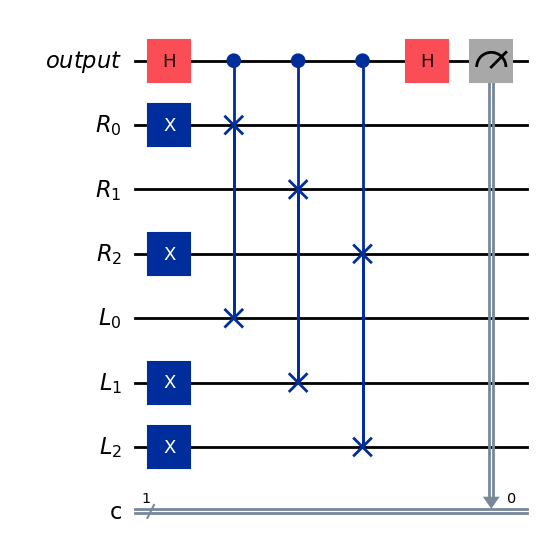

In [14]:
# Show example circuit
example_circuit = swap_test_3qubit(5, 3)
print("Circuit comparing |5⟩ = |101⟩ vs |3⟩ = |011⟩:")
print("Depth:", example_circuit.depth())
print("Gate counts:", example_circuit.count_ops())

example_circuit.draw('mpl')

### Task B.2 — Superposition variant

#### 1. Modified Circuit with Superposition

In [15]:
def swap_test_3qubit_superposition(k_ref, k_test):
    """Build SWAP-test circuit with superposition on L[0] after basis preparation."""
    output = QuantumRegister(1, 'output')
    R = QuantumRegister(3, 'R')  # reference
    L = QuantumRegister(3, 'L')  # test
    cbit = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(output, R, L, cbit)

    # Prepare basis states
    basis_state_prep(qc, R, k_ref)
    basis_state_prep(qc, L, k_test)
    
    # Add superposition to L[0] AFTER basis preparation
    qc.h(L[0])

    # SWAP test
    qc.h(output[0])
    for i in range(3):
        qc.cswap(output[0], R[i], L[i])
    qc.h(output[0])

    qc.measure(output[0], cbit[0])
    return qc

#### Rerun simulation with superposition

In [16]:
sim = AerSimulator()
shots_list = [1000, 2000, 4000]
k_ref = 5

results_super = []
for shots in shots_list:
    # Positive case with superposition
    qc_pos = swap_test_3qubit_superposition(k_ref, k_ref)
    t_qc = transpile(qc_pos, sim)
    counts = sim.run(t_qc, shots=shots).result().get_counts()
    f_pos_b2, se_pos_b2 = fidelity_and_se(counts, shots)
    
    # Negative cases with superposition
    f_negs_b2 = []
    se_negs_b2 = []
    for k in range(8):
        if k == k_ref: 
            continue
        qc_neg = swap_test_3qubit_superposition(k_ref, k)
        t_qc = transpile(qc_neg, sim)
        counts = sim.run(t_qc, shots=shots).result().get_counts()
        f_neg, se_neg = fidelity_and_se(counts, shots)
        f_negs_b2.append(f_neg)
        se_negs_b2.append(se_neg)
    
    mean_neg_superpos = float(np.mean(f_negs_b2))
    mean_se_neg = float(np.mean(se_negs_b2)) # mean of the SEs, not SE of the mean

    results_super.append({'shots': shots,
                          'Fidelity k=5': float(f_pos_b2),
                          'SE k=5': float(se_pos_b2),
                          'Fidelity k!=5': mean_neg_superpos,
                          'SE k!=5': mean_se_neg})

print(tabulate(results_super, headers="keys", tablefmt="github", showindex=False))

|   shots |   Fidelity k=5 |    SE k=5 |   Fidelity k!=5 |   SE k!=5 |
|---------|----------------|-----------|-----------------|-----------|
|    1000 |          0.49  | 0.0275663 |       0.0757143 | 0.0310199 |
|    2000 |          0.512 | 0.0192075 |       0.0701429 | 0.0219608 |
|    4000 |          0.51  | 0.0136006 |       0.0803571 | 0.0155103 |


#### Compare B.1 vs B.2 at 4000 shots

In [17]:
b1_4k = next(r for r in results if r['shots'] == 4000)
b2_4k = next(r for r in results_super if r['shots'] == 4000)
comparison = [
    {'Method': 'B.1 (Basis)', 'Fidelity k=5': b1_4k['Fidelity k=5'], 'Fidelity k!=5': b1_4k['Fidelity k!=5'], 'SE k!=5': b1_4k['SE k!=5']},
    {'Method': 'B.2 (Superposition)', 'Fidelity k=5': b2_4k['Fidelity k=5'], 'Fidelity k!=5': b2_4k['Fidelity k!=5'], 'SE k!=5': b2_4k['SE k!=5']}
]
print(tabulate(comparison, headers="keys", tablefmt="github", showindex=False))

| Method              |   Fidelity k=5 |   Fidelity k!=5 |   SE k!=5 |
|---------------------|----------------|-----------------|-----------|
| B.1 (Basis)         |           1    |     0.000642857 | 0.0158112 |
| B.2 (Superposition) |           0.51 |     0.0803571   | 0.0155103 |


#### Compare individual k values at 4000 shots

In [18]:
comparison_individual = [
    {'Type': 'B.1 (Basis)', 'Fid k=5': f_pos_b1, 'Fid k=0': f_negs_b1[0], 'Fid k=1': f_negs_b1[1], 'Fid k=2': f_negs_b1[2],
     'Fid k=3': f_negs_b1[3], 'Fid k=4': f_negs_b1[4], 'Fid k=6': f_negs_b1[5], 'Fid k=7': f_negs_b1[6]},
    {'Type': 'B.2 (Superposition)', 'Fid k=5': f_pos_b2, 'Fid k=0': f_negs_b2[0], 'Fid k=1': f_negs_b2[1], 'Fid k=2': f_negs_b2[2],
     'Fid k=3': f_negs_b2[3], 'Fid k=4': f_negs_b2[4], 'Fid k=6': f_negs_b2[5], 'Fid k=7': f_negs_b2[6]}
]

print(tabulate(comparison_individual, headers="keys", tablefmt="github", showindex=False))

| Type                |   Fid k=5 |   Fid k=0 |   Fid k=1 |   Fid k=2 |   Fid k=3 |   Fid k=4 |   Fid k=6 |   Fid k=7 |
|---------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| B.1 (Basis)         |      1    |     0     |    0.001  |     0     |         0 |         0 |    0.001  |    0.0025 |
| B.2 (Superposition) |      0.51 |     0.024 |    0.4975 |     0.015 |         0 |         0 |    0.0035 |    0.0225 |


#### Discussion
1. **Do some negatives (k≠5) show larger F_est?** Yes. Some k values show higher fidelity due to superpositions like (|k⟩ + |k±1⟩)/√2 after H(L[0]), where quantum interference in the SWAP test boosts measured fidelity beyond shot noise.
2. **Why do some states have higher fidelity?** Constructive interference in superpositions can increase overlap with |5⟩, even if no basis state directly matches the reference.
3. **Would B.1 strategy still work?** No. Some negatives can exceed the 0.5 threshold, making simple thresholding unreliable; a higher threshold or different approach is needed.

#### Reflection
**What changed:** Superposition spreads amplitude over two basis states, creating quantum interference effects that weren't present in the pure basis state comparison.

**Impact:** Some k≠5 cases now show significant fidelity with |5⟩ due to constructive interference in the SWAP test measurement, even when neither basis component directly matches the reference state.

**Improvement to try:** Use adaptive threshold based on statistical confidence intervals, or implement multi-shot validation with majority voting to distinguish genuine state equality from interference-induced high fidelity.

## AI Assistance Disclosure

**Tool used:** ChatGPT (GPT-5 mini)  

**Usage:** Used to review and improve explanatory text and help implementing standard error calculations.